# The second example

from here: https://quantumcomputing.stackexchange.com/questions/15781/hhl-algorithm-how-can-i-get-result-from-register-b-rangle

In [101]:
# https://quantumcomputing.stackexchange.com/questions/24050/how-to-implement-a-exponential-of-a-hamiltonian-but-non-unitary-matrix-in-qisk

# control gate: https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html

# circuit https://www.nature.com/articles/s41598-022-17660-8
import numpy as np

from qiskit.circuit import ControlledGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.tools.visualization import plot_histogram

from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Operator, DensityMatrix, Statevector

In [36]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.list_ops import SummedOp
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
A = np.array([
    [1.5, 0.5],
    [0.5, 1.5],
    ]).astype('complex')

b = np.array([0, 1]).T

In [37]:
def get_gate(A, n):    
    pauli_op = PauliSumOp(SparsePauliOp.from_operator(A))
    phi = Parameter('ϕ')
    evolution_op = (phi * pauli_op).exp_i() # exp(-iϕA)
    trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op).bind_parameters({phi: np.pi/n})
    #----control---------
    gate = trotterized_op.to_circuit()
    # print(gate)
    gate.name = f"e^(i*A*pi/{n})"
    gate.label = f"e^(i*A*np.pi/{n})"
    gate = gate.to_gate().control()
    #---------------------
    return gate

In [154]:
n_b = 1
n_ = 3
n_ancilla = 1
n_cl = 2
# quantum circuit initialization
qc = QuantumCircuit(n_b + n_ + n_ancilla, 1)
# b-vector state preparation
for i in range(n_b):
    qc.x(i)
for i in range(n_b, n_b+n_):
    qc.h(i)
qc.barrier()
# Matrix exponentiation
for i in range(0, n_):
    gate = get_gate(A, 2**(i+1))
    qc.append(gate,[i+1, 0])
qc.barrier()
# # # Phase estimation
for j in range(n_b + n_ - 1, n_b, -1):
    qc.h(j)
    for m in range(j - n_b):
        qc.crz(-np.pi/float(2**(j-m - n_b)), j, m+n_b)
qc.h(j-1)
qc.barrier()
# # As I understood, we wncode ancilla qubit to be sure that result will be correct
for j in range(1, 1+n_):
    qc.cry(np.pi/(2**j), n_b+n_-j, n_b+n_)
qc.barrier()
# # Inverse quantum Fourier transform
for j in range(n_b, n_b + n_):
    for m in range(j - n_b):
        qc.crz(np.pi/float(2**(j-m - n_b)), j, m+n_b)
    qc.h(j)
qc.h(n_b)
qc.barrier()
# # Eigenvalues storing in the vecor b register
for i in range(n_, 0, -1):
    gate = get_gate(A, -(2**(i)))
    qc.append(gate,[i, 0])
qc.barrier()
# qubits measurement. I do not measure the ancilla qubit
# print(np.round(Operator.from_circuit(qc), 3))
# np.round(DensityMatrix.from_instruction(qc).data, 2)
vec = Statevector.from_instruction(qc).data
# print(np.round(vec, 2))
vec = np.array([[vec[i]] for i in range(len(vec))])
# print(vec)
rho = np.dot(vec, vec.T)
print(rho)
DensityMatrix.from_instruction(qc).data
# print(np.round(rho,2))
# print(np.round(rho.T, 2))
# qc.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

[[-0.0136336 -0.03243417j  0.01251298+0.02774861j  0.02368451-0.00928598j
  ...  0.015501  +0.00241086j  0.00953691-0.01901976j
  -0.01093438-0.03465409j]
 [ 0.01251298+0.02774861j -0.01143955-0.02372106j -0.02027785+0.00855815j
  ... -0.01346023-0.00174032j -0.00782527+0.01666208j
   0.01022784+0.02972863j]
 [ 0.02368451-0.00928598j -0.02027785+0.00855815j  0.00629681+0.01728346j
  ... -0.00201472+0.01116269j  0.01358121+0.00722759j
   0.02524183-0.00729587j]
 ...
 [ 0.015501  +0.00241086j -0.01346023-0.00174032j -0.00201472+0.01116269j
  ... -0.0045408 +0.00532035j  0.00498933+0.0080689j
   0.01571235+0.00395473j]
 [ 0.00953691-0.01901976j -0.00782527+0.01666208j  0.01358121+0.00722759j
  ...  0.00498933+0.0080689j   0.01248811-0.00309984j
   0.01161832-0.01865296j]
 [-0.01093438-0.03465409j  0.01022784+0.02972863j  0.02524183-0.00729587j
  ...  0.01571235+0.00395473j  0.01161832-0.01865296j
  -0.00794712-0.03668025j]]


array([[ 0.0351831 +5.20417043e-18j, -0.03042938-7.82610823e-04j,
        -0.0006174 -2.54323417e-02j, ..., -0.0082292 -1.33556513e-02j,
         0.01383812-1.61620098e-02j,  0.03618362-3.34855530e-03j],
       [-0.03042938+7.82610823e-04j,  0.02633537+1.73472348e-17j,
         0.0010997 +2.19823559e-02j, ...,  0.0074144 +1.13680729e-02j,
        -0.01160889+1.42861187e-02j, -0.03122024+3.70098667e-03j],
       [-0.0006174 +2.54323417e-02j,  0.0010997 -2.19823559e-02j,
         0.01839478+0.00000000e+00j, ...,  0.00979863-5.71416252e-03j,
         0.01143998+1.02865935e-02j,  0.00178556+2.62143360e-02j],
       ...,
       [-0.0082292 +1.33556513e-02j,  0.0074144 -1.13680729e-02j,
         0.00979863+5.71416252e-03j, ...,  0.00699464+6.50521303e-18j,
         0.00289848+9.03324236e-03j, -0.00719209+1.45186678e-02j],
       [ 0.01383812+1.61620098e-02j, -0.01160889-1.42861187e-02j,
         0.01143998-1.02865935e-02j, ...,  0.00289848-9.03324236e-03j,
         0.01286709+4.33680869e-18j

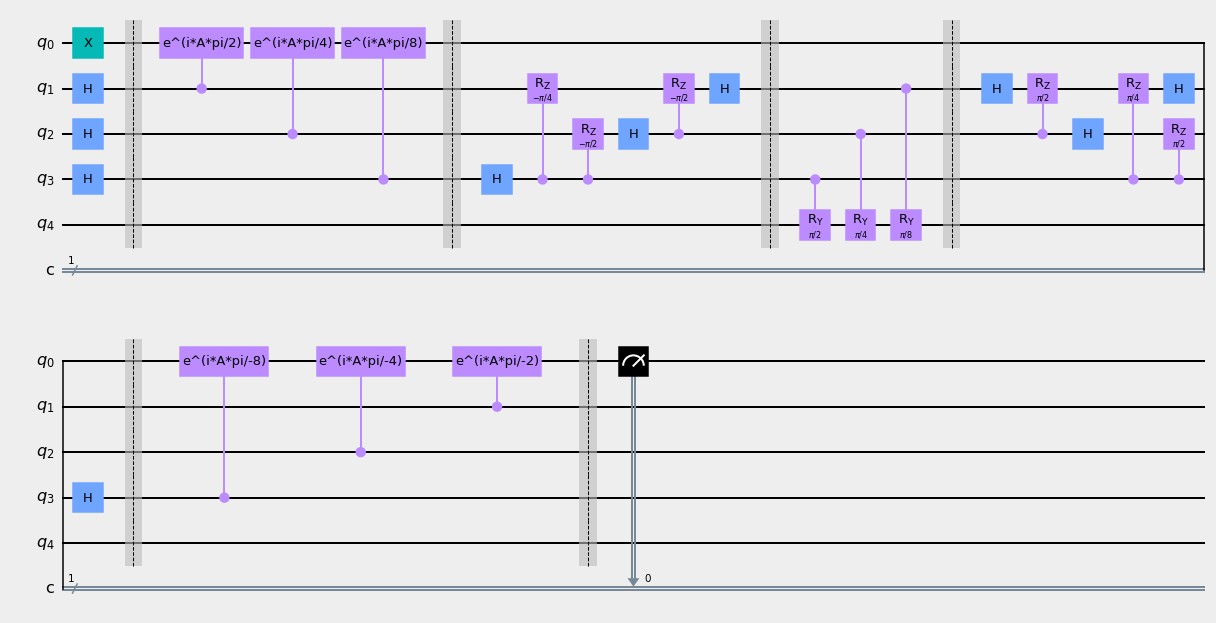

In [116]:
# qc.measure(-1, 1)
qc.measure(0, 0)
qc.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

In [125]:
simulator = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator)
shots = 10000
result = execute(qc, backend=simulator, shots=shots).result()

# Calculated result

In [126]:
counts = result.get_counts()
probabilities = counts.copy()
for k, v in probabilities.items():
    probabilities[k] = v/shots
probabilities

{'1': 0.7315, '0': 0.2685}

# Real x-vector result

In [68]:
print(
    'real is',
    1/32,
    -1/32,
    1/16,
    1/8
)

real is 0.03125 -0.03125 0.0625 0.125


# Result x-vector from paper

In [69]:
print(
    np.sqrt(0.0455),
    np.sqrt(0.0455),
    np.sqrt(0.1818),
    np.sqrt(0.7272)
)

0.2133072900770154 0.2133072900770154 0.42638011210655685 0.8527602242131137


In [101]:
0.0455+0.0455+0.1818+0.7272

1.0

# Normalization of real x-vector result

In [106]:
a = [0.03125, -0.03125, 0.0625, 0.125]

from sklearn.preprocessing import normalize
norm1 = np.array(a) / np.linalg.norm(a)
norm1**2

array([0.04545455, 0.04545455, 0.18181818, 0.72727273])